# SENDY LOGISTICS EXPLORITORY DATA ANALYSIS 
---
1. Make your **1st line a comment**, just to give clarity to the Team about the task/code used.
2. If you happen to get a **CODE snippet** from **stackoverflow/Blog**, Make your **2nd line the link referencing the code/post**. for later reference if team members need clarity.

---
## HEADS UP
*The following steps will serve as a guide-line not mandatory step and they might not be in order.*




# 1. Library Imports
---
Keep it clean, import Libraries at the Top!

In [1]:
# data manipulation
import pandas as pd
import numpy as np
from scipy.stats import norm
from scipy import stats

# data visualization
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

# More imports Below


# 2. Import Datasets
---
- By Default the notebook is using the github links to fetch data remotely, change to local if need be. 
> e.g replace URL_TRAIN with URL_local_TRAIN
- DO NOT FORGET TO CHANGE BACK THE LINKS BEFORE CREATING A PULL REQUEST
> Use The following Links for Local Machine NoteBooks/Jupyterlab (this will save data)
>This assumes the notebook.ipynb is inside the Notebooks folder

```python
URL_local_TRAIN = "/data/Train.csv"
URL_local_TEST = "/data/Test.csv"
URL_local_RIDERS = "/data/Riders.csv" 
URL_local_DD = "/data/VariableDefinitions.csv"

```
---

In [2]:
# CONSTANTS

URL_TRAIN = "https://raw.githubusercontent.com/Explore-EDSA-2020/Sendy-Logistics-Challenge/master/data/Train.csv"
URL_TEST = "https://raw.githubusercontent.com/Explore-EDSA-2020/Sendy-Logistics-Challenge/master/data/Test.csv"
URL_RIDERS = "https://raw.githubusercontent.com/Explore-EDSA-2020/Sendy-Logistics-Challenge/master/data/Riders.csv" 
URL_DD = "https://raw.githubusercontent.com/Explore-EDSA-2020/Sendy-Logistics-Challenge/master/data/VariableDefinitions.csv" # Data Dictionary


In [3]:
# reading the data to dataframe

train_df  = pd.read_csv(URL_TRAIN)
test_df   = pd.read_csv(URL_TEST)
riders_df = pd.read_csv(URL_RIDERS)
data_dictionary_df = pd.read_csv(URL_DD)

In [4]:
# making a copy of the data to avoid altering the original data
train_riders = train_df.copy()
test_riders  = test_df.copy()

# merged train with riders
train_riders = train_riders.merge(riders_df, how='left', on='Rider Id')
test_riders  = test_riders.merge(riders_df, how='left', on='Rider Id')

# view dimension
print('train without riders: ', train_df.shape)
print('train merged with riders: ', train_riders.shape)
print('---------------------------------------')
print('test without riders: ', test_df.shape)
print('test merged with riders: ', test_riders.shape)

train without riders:  (21201, 29)
train merged with riders:  (21201, 33)
---------------------------------------
test without riders:  (7068, 25)
test merged with riders:  (7068, 29)


# 3. DOMAIN KNOWLEDGE
---
Read the Data Dictionary to Understand what each Feature Holds.

### Variables

**1. Order details**
- Order No – Unique number identifying the order
- User Id – Unique number identifying the customer on a platform
- Vehicle Type – For this competition limited to bikes, however in practice, Sendy service extends to trucks and vans
- Platform Type – Platform used to place the order, there are 4 types
- Personal or Business – Customer type

**2. Placement times**
- Placement - Day of Month i.e 1-31
- Placement - Weekday (Monday = 1)
- Placement - Time - Time of day the order was placed

**3. Confirmation times**
- Confirmation - Day of Month i.e 1-31
- Confirmation - Weekday (Monday = 1)
- Confirmation - Time - time of day the order was confirmed by a rider

**4. Arrival at Pickup times**
Arrival at Pickup - Day of Month i.e 1-31
Arrival at Pickup - Weekday (Monday = 1)
Arrival at Pickup - Time - Time of day the rider arrived at the location to pick up the order - as marked by the rider through the Sendy application

**5. Pickup times**
- Pickup - Day of Month i.e 1-31
- Pickup - Weekday (Monday = 1)
- Pickup - Time - Time of day the rider picked up the order - as marked by the rider through the Sendy application


**Arrival at Destination times (column missing in Test set)**

- Arrival at Delivery - Day of Month i.e 1-31
- Arrival at Delivery - Weekday (Monday = 1)
- Arrival at Delivery - Time - Time of day the rider arrived at the destination to deliver the order - as marked by the rider through the Sendy application
- Distance covered (KM) - The distance from Pickup to Destination

- Temperature -Temperature at the time of order placement in Degrees Celsius (measured every three hours)
- Precipitation in Millimeters - Precipitation at the time of order placement (measured every three hours)
- Pickup Latitude and Longitude - Latitude and longitude of pick up location
- Destination Latitude and Longitude - Latitude and longitude of delivery location
- Rider ID – ID of the Rider who accepted the order
- Time from Pickup to Arrival - Time in seconds between ‘Pickup’ and ‘Arrival at Destination’ - calculated from the columns for the purpose of facilitating the task

**Rider metrics**
- Rider ID – Unique number identifying the rider (same as in order details)
- No of Orders – Number of Orders the rider has delivered
- Age – Number of days since the rider delivered the first order
- Average Rating – Average rating of the rider
- No of Ratings - Number of ratings the rider has received. Rating an order is optional for the customer.

# **Custom Functions**
---
all user defined functions will be written in this section.

In [5]:
def datetime_to_seconds(df):
    """Returns a dataframe with time converted to seconds"""
    for col in df.columns:
      if col.endswith('Time'):
           df[col] = pd.to_datetime(df[col])
           df[col]= (df[col] - pd.to_datetime(pd.to_datetime('today').date())).astype('timedelta64[s]')
           return df


In [6]:
def get_Duplicate_Columns(df):
    '''
    Get a list of duplicate columns.
    It will iterate over all the columns in dataframe and find the columns whose contents are duplicate.
    :param df: Dataframe object
    :return: List of columns whose contents are duplicates.
    '''
    duplicateColumnNames = set()
    # Iterate over all the columns in dataframe
    for x in range(df.shape[1]):
        # Select column at xth index.
        col = df.iloc[:, x]
        # Iterate over all the columns in DataFrame from (x+1)th index till end
        for y in range(x + 1, df.shape[1]):
            # Select column at yth index.
            otherCol = df.iloc[:, y]
            # Check if two columns at x 7 y index are equal
            if col.equals(otherCol):
                duplicateColumnNames.add(df.columns.values[y])
                
    return list(duplicateColumnNames)

In [7]:
def get_missing_values(df, threshold =0):
    """Returns the feature name and the % of  missing values as dataframe"""

    return pd.DataFrame(data= {column: (df[column].isnull().mean()) for column in df.columns if df[column].isnull().mean() > threshold}, 
             index=['% of Missing values']
             ).T

In [8]:
def get_cadinality(df , threshold=0):
    
    return pd.DataFrame(data= {column: (df[column].nunique()) for column in df.columns if df[column].nunique() < threshold}, 
             index=['Cardinality per Feature']
             ).T

In [9]:
def to_weekday_name(df, ends_with):

    weekday_names = {1:"Monday", 2:"Tuesday", 3: "Wednesday", 4:"Thursday", 5:"Friday", 6: "Saturday", 7:"Sunday"}
    for col in df.columns:
        if col.endswith(ends_with):
           df[col] = df[col].map(weekday_names) 
    
    return df


In [10]:
def to_platform_type(df):
    """Returns a dataframe with encoded platform feature"""

    types = {1:'Type 1',2:'Type 2',3:'Type 3',4:'Type 4'}

    df['Platform Type'] = df['Platform Type'].map(types)
    
    return df

In [11]:
# Lets get the features that are highly correlated with price
def get_correlated_feature(corrdata, target: str , threshold:float):
    """Returns  features with a custom correlation threshold with the target """
    
    corrdata = df.corr('pearson')
    return pd.DataFrame({name: [corrdata[name][target]]  for name in corrdata.index 
                     if abs(corrdata[name][target]) > threshold },
                     index=['Corr value']).T
        

# 4. QUICK DATA OVERVIEW
---
What seems to be odd?

**------------------------------riders data------------------------------**

In [12]:
# Riders data overview 
riders_df

,Rider Id,No_Of_Orders,Age,Average_Rating,No_of_Ratings
0,Rider_Id_396,2946,2298,14.0,1159
1,Rider_Id_479,360,951,13.5,176
2,Rider_Id_648,1746,821,14.3,466
3,Rider_Id_753,314,980,12.5,75
4,Rider_Id_335,536,1113,13.7,156
...,...,...,...,...,...
955,Rider_Id_896,152,99,12.4,18
956,Rider_Id_149,69,101,10.2,10
957,Rider_Id_270,338,96,14.4,41
958,Rider_Id_201,159,96,15.0,9


In [ ]:
# investigate missing values and the data type 
riders_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 960 entries, 0 to 959
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Rider Id        960 non-null    object 
 1   No_Of_Orders    960 non-null    int64  
 2   Age             960 non-null    int64  
 3   Average_Rating  960 non-null    float64
 4   No_of_Ratings   960 non-null    int64  
dtypes: float64(1), int64(3), object(1)
memory usage: 37.6+ KB


In [12]:
# check if really the rider's id is unique, to understand how many riders do we have
riders_df['Rider Id'].nunique()

960

In [ ]:
# get the summary statistics of the riders
# We wish to undersatnd the average number of orders made, later on we will check per rider
riders_df.describe()

,No_Of_Orders,Age,Average_Rating,No_of_Ratings
count,960.000000,960.000000,960.000000,960.000000
mean,1864.851042,1200.234375,13.412604,427.983333
std,1880.337785,810.930171,2.675794,486.957931
min,2.000000,96.000000,0.000000,0.000000
25%,261.750000,478.250000,13.500000,30.000000
50%,1475.500000,1021.000000,14.000000,223.000000
75%,2847.250000,1891.500000,14.300000,678.750000
max,9756.000000,3764.000000,15.200000,2298.000000


NOTES:
- So we have **960 unique riders** with No Missing Values
- we should later try to investigate existing outliers. 
- on avarage the orders collected by the riders is **1864.851042** with MAX = **9756.000000**
- The Age seems to represent exprience of the riders, meaning Age above 50% the rider must be some-how faster at delivary. does that better explain the target?
- Assupmtions are:
   - Age < 25% basic rider (25% of the riders are basic riders)
   - Age < 50% or Age <= 1200.234375 Intermediate rider
   - Age < 75% Advanced rider
   - This might be a potential feature e.g **riders_rank-->   {basic, Intermediate, Advanced }**
- interesting features are:
    - Age	 
    - Average_Rating	
    - No_of_Ratings 	
    
> whats's the method used to rate the riders, what factor rate?

> Does Age and No of orders better explain the target?

**------------------------------Train data with riders------------------------------**

In [13]:
# Lets verify what we got from domain knowledge section
# get columns from train and test
column_train = train_riders.columns.to_list()
column_test = test_riders.columns.to_list()

# get columns in trains but not in test excluding the target
[column for column in column_train if column not in column_test and column !=  'Time from Pickup to Arrival']

['Arrival at Destination - Day of Month',
 'Arrival at Destination - Weekday (Mo = 1)',
 'Arrival at Destination - Time']

In [14]:
# view the 1st 5 observations
train_riders.head()

,Order No,User Id,Vehicle Type,Platform Type,Personal or Business,Placement - Day of Month,Placement - Weekday (Mo = 1),Placement - Time,Confirmation - Day of Month,Confirmation - Weekday (Mo = 1),...,Pickup Lat,Pickup Long,Destination Lat,Destination Long,Rider Id,Time from Pickup to Arrival,No_Of_Orders,Age,Average_Rating,No_of_Ratings
0,Order_No_4211,User_Id_633,Bike,3,Business,9,5,9:35:46 AM,9,5,...,-1.317755,36.830370,-1.300406,36.829741,Rider_Id_432,745,1637,1309,13.8,549
1,Order_No_25375,User_Id_2285,Bike,3,Personal,12,5,11:16:16 AM,12,5,...,-1.351453,36.899315,-1.295004,36.814358,Rider_Id_856,1993,396,339,13.6,69
2,Order_No_1899,User_Id_265,Bike,3,Business,30,2,12:39:25 PM,30,2,...,-1.308284,36.843419,-1.300921,36.828195,Rider_Id_155,455,1023,242,12.5,114
3,Order_No_9336,User_Id_1402,Bike,3,Business,15,5,9:25:34 AM,15,5,...,-1.281301,36.832396,-1.257147,36.795063,Rider_Id_855,1341,886,283,14.5,113
4,Order_No_27883,User_Id_1737,Bike,1,Personal,13,1,9:55:18 AM,13,1,...,-1.266597,36.792118,-1.295041,36.809817,Rider_Id_770,1214,2311,872,14.1,533


In [15]:
# get the dimension
train_riders.shape

(21201, 33)

In [16]:
# investigate missing values and data types
train_riders.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21201 entries, 0 to 21200
Data columns (total 33 columns):
 #   Column                                     Non-Null Count  Dtype  
---  ------                                     --------------  -----  
 0   Order No                                   21201 non-null  object 
 1   User Id                                    21201 non-null  object 
 2   Vehicle Type                               21201 non-null  object 
 3   Platform Type                              21201 non-null  int64  
 4   Personal or Business                       21201 non-null  object 
 5   Placement - Day of Month                   21201 non-null  int64  
 6   Placement - Weekday (Mo = 1)               21201 non-null  int64  
 7   Placement - Time                           21201 non-null  object 
 8   Confirmation - Day of Month                21201 non-null  int64  
 9   Confirmation - Weekday (Mo = 1)            21201 non-null  int64  
 10  Confirmation - Time   

In [ ]:
# get % of missing values
get_missing_values(train_riders)

,% of Missing values
Temperature,0.205934
Precipitation in millimeters,0.973963


In [ ]:
# After we merged let's check the No rider's id is unique.
# To understand how many riders were excluded and we must also verify on the test set
train_riders['Rider Id'].nunique()

924

In [17]:
# investigate the orders based on Personal or Business
# using  Time and Weekday
train_riders.groupby(['Personal or Business','Placement - Time','Placement - Weekday (Mo = 1)', 'Confirmation - Time']).count()['Arrival at Destination - Time']

Personal or Business  Placement - Time  Placement - Weekday (Mo = 1)  Confirmation - Time
Business              10:00:05 AM       6                             10:00:45 AM            1
                      10:00:06 AM       1                             10:00:25 AM            1
                                        4                             10:00:21 AM            1
                      10:00:09 AM       2                             10:00:26 AM            1
                      10:00:11 AM       3                             10:01:10 AM            1
                                                                                            ..
Personal              9:59:23 AM        2                             10:15:39 AM            1
                      9:59:29 AM        2                             10:00:56 AM            1
                      9:59:36 AM        1                             10:04:51 AM            1
                      9:59:42 AM        3              

In [18]:
# check cardinality 
get_cadinality(train_riders, 16)

,Cardinality per Feature
Vehicle Type,1
Platform Type,4
Personal or Business,2
Placement - Weekday (Mo = 1),7
Confirmation - Weekday (Mo = 1),7
Arrival at Pickup - Weekday (Mo = 1),7
Pickup - Weekday (Mo = 1),7
Arrival at Destination - Weekday (Mo = 1),7


**We have redundant Features!**

---
All the orders seems to be one day deal per trip. mean **Placement - Weekday** must be equal **Confirmation - Weekday**, etc.

> **Let us investigate if** 
- Placement - Weekday (Mo = 1) != Confirmation - Weekday (Mo = 1)
- Arrival at Pickup - Weekday (Mo = 1) != Arrival at Destination - Weekday (Mo = 1)	
- Arrival at Pickup - Weekday != Placement - Weekday (Mo = 1)
- Pickup - Day of Month != Destination - Day of Month
- Placement - Day of Month != Confirmation - Day of Month


> We create a custom function to detect duplicate Features by elements
> **This mean they are all equal and we shall keep:**
  - Weekday (Mo = 1)
  - Day of Month




In [ ]:
get_Duplicate_Columns(train_riders)

['Arrival at Pickup - Day of Month',
 'Pickup - Day of Month',
 'Arrival at Pickup - Weekday (Mo = 1)',
 'Arrival at Destination - Day of Month',
 'Pickup - Weekday (Mo = 1)',
 'Arrival at Destination - Weekday (Mo = 1)']

> Note: 

**------------------------------Test data with riders------------------------------**

# 5. Visualizations
---
**The 3 ways tree branches to understand the data**
1. Composition
2. Comparison
3. RelationShips
---
Take it from here!

In [19]:
# making a copy of dataframe
train_prep = train_riders.copy()

In [20]:
# drop duplicates
duplicates = get_Duplicate_Columns(train_prep)
train_prep = train_prep.drop(columns=get_Duplicate_Columns(train_prep), axis=1)
train_prep = train_prep.drop(columns=[ 'Confirmation - Day of Month',
                                      'Confirmation - Weekday (Mo = 1)',
                                      'Vehicle Type','User Id','Precipitation in millimeters'], axis=1)
print(duplicates)


['Arrival at Pickup - Day of Month', 'Pickup - Weekday (Mo = 1)', 'Pickup - Day of Month', 'Arrival at Destination - Day of Month', 'Arrival at Destination - Weekday (Mo = 1)', 'Arrival at Pickup - Weekday (Mo = 1)']


In [21]:
# encode weekdays numbers to names
train_prep = to_weekday_name(train_prep, 'Weekday (Mo = 1)')

# rename Features names
train_prep.rename(columns={'Personal or Business':'Customer Type',
                           'Placement - Weekday (Mo = 1)': 'Weekday (Mo = 1)',
                           'Placement - Day of Month': 'Day of Month'}, inplace=True)

# encoding platform types 
train_prep= to_platform_type(train_prep)

In [22]:
print(train_prep.shape)
train_prep.sample()

(21201, 22)


,Order No,Platform Type,Customer Type,Day of Month,Weekday (Mo = 1),Placement - Time,Confirmation - Time,Arrival at Pickup - Time,Pickup - Time,Arrival at Destination - Time,...,Pickup Lat,Pickup Long,Destination Lat,Destination Long,Rider Id,Time from Pickup to Arrival,No_Of_Orders,Age,Average_Rating,No_of_Ratings
11745,Order_No_27117,Type 3,Business,1,Monday,11:45:34 AM,11:46:53 AM,11:57:06 AM,12:13:15 PM,12:24:20 PM,...,-1.304735,36.784605,-1.265164,36.807221,Rider_Id_958,665,1907,530,13.8,305


In [17]:
# convert to seconds, all features with column name ending with Time, run it only once!  
train_prep = datetime_to_seconds(train_prep)

# Report:
*To Do*

---
What worked so far:
- managed to get hiden glitches from train data.
- removed duplicates
- more to be explain during meeting.


**Create time based feature:**
> Timedelta <br>
> is_not_weeked / is_weeked <br>
> Rush hours <br>
> time of the day {morning, afternoon, evening} <br>
> seasonality or quarter of month or year<br>
<br>
>  Pickup-Time
  - hour 
  - minutes

> Confirmation-Time
  - hour 
  - minutes
  - Seconds

> Destination - Time
  - hour 
  - minutes
  - Seconds

**Create geo based features**
- Distance

**Riders features**
> riders exprience based on age {years, months, days} <br>
> factor rating

**Last but important**
> check linear regression assumptions


# **Multivariate Plot**
---


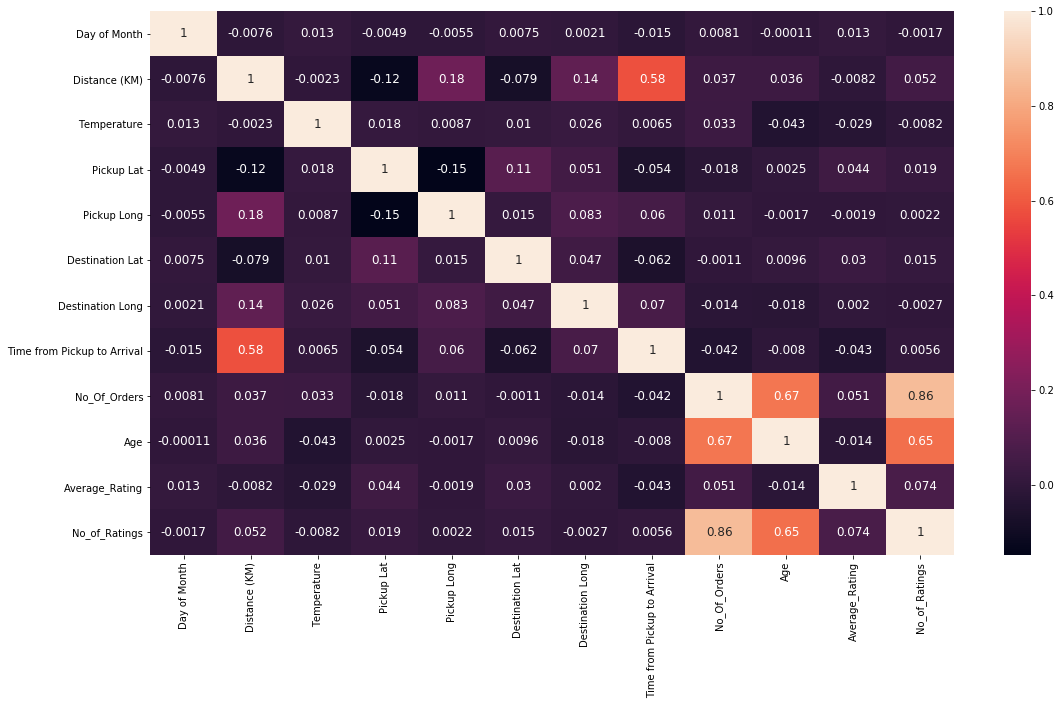

In [23]:
# plot a heatmap conveying the correlation of the variables
cormat = train_prep.corr(method='pearson')
# set figsize
fig, ax = plt.subplots(figsize=(18,10))

# plot heatmap with cormat
sns.heatmap(data=cormat, annot=True, annot_kws={'size':12})
plt.show()

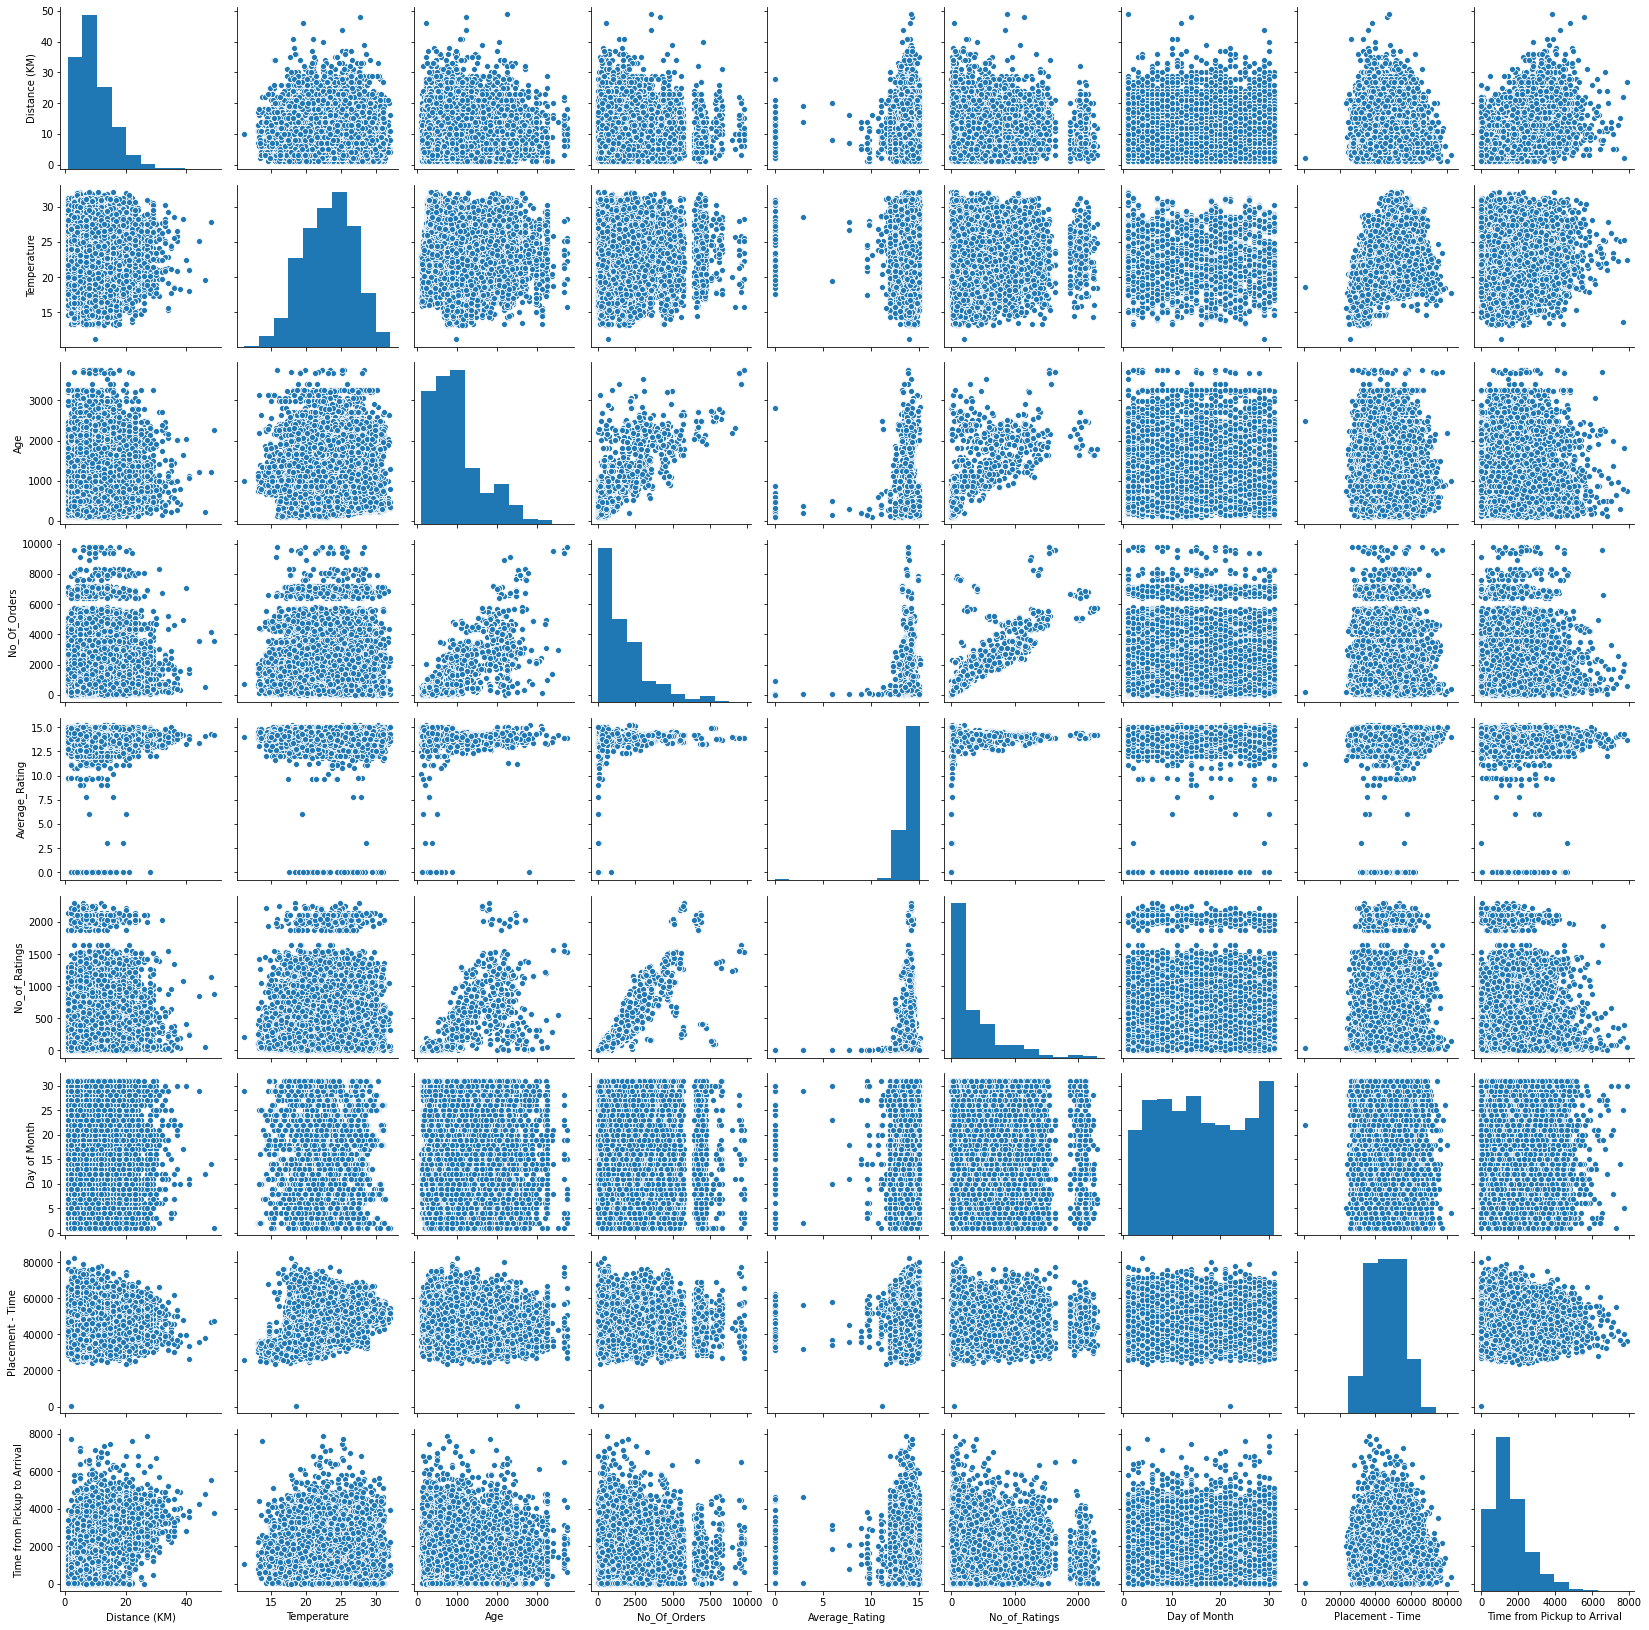

In [ ]:
sns.pairplot(train_prep[['Distance (KM)', 'Temperature','Age','No_Of_Orders',
                'Average_Rating','No_of_Ratings','Day of Month','Placement - Time',
                'Confirmation - Time','Arrival at Pickup - Time',
                'Arrival at Destination - Time','Time from Pickup to Arrival']])

# **Univariate Plots**
**Let's See Drill Through with visuals** 
---

composition plots

> we have two customer types, **Personal & Business**:
  - Which customer type orders more from sendy ?

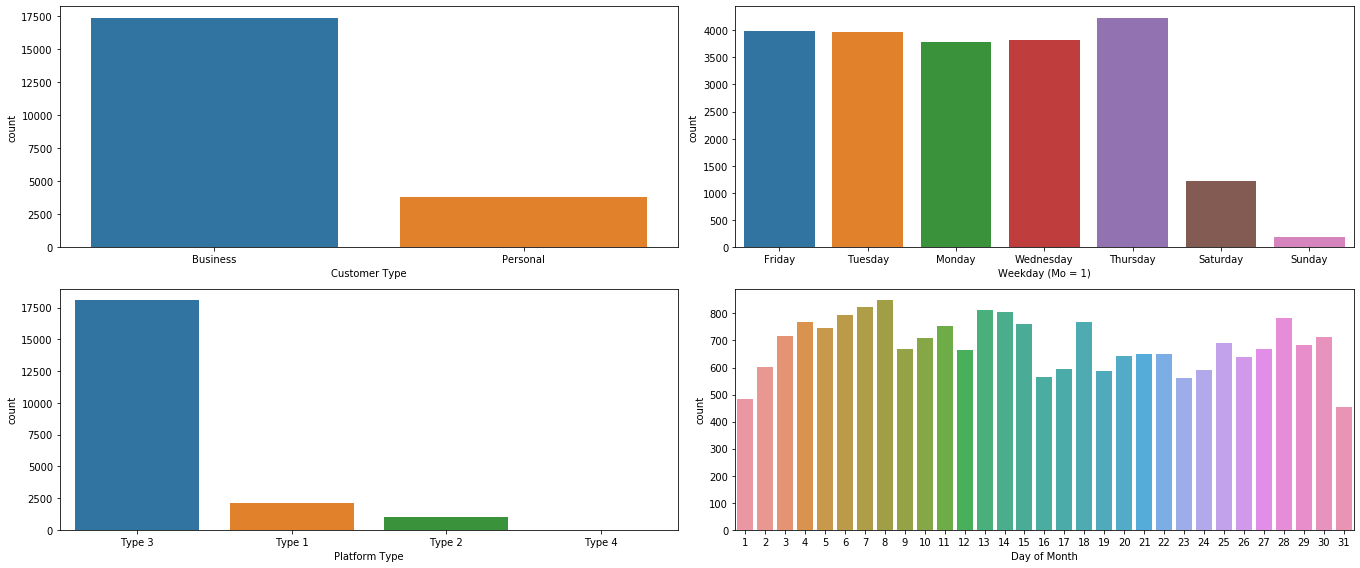

In [25]:
# distribution plot 
rows = 2
cols = 2

# setup layout for subplots
fig, ax = plt.subplots(nrows=rows, ncols=cols, figsize=(19,8))


# get number of columns
columns = ['Customer Type', 'Weekday (Mo = 1)', 'Platform Type', 'Day of Month']
# train_riders
index = 0

for row in range(rows):
    for col in range(cols):
        sns.countplot(train_prep[columns[index]], ax=ax[row][col], )
        index +=1


# fix squeezed layout
plt.tight_layout()

**customer type**
---
We have came to the realization that when it comes to business and personal the business has more orders.

---
**weekday vs count**
---
we have came to realization that the highest orders are made on thursday where we had more than 4000 orders. 
followed by friday and tuesday where we had ecxatly 4000 orders.Orders made on monday and wensday are
also high because we have 3000 orders.The lowest orders were made on weekend,we had about 1200 orders on saturday and less than 500 orders on sunday.

** Platform type vs ccount**
---
we observe that type 3 platform has more counts compared to type 1 ,type 2 and type 4
where type 4 is even worse because is 0.

** day of month vs count**
---
the number of orders flactuate with days.


In [ ]:
train_prep.columns

Index(['Order No', 'Platform Type', 'Customer Type', 'Day of Month',
       'Weekday (Mo = 1)', 'Placement - Time', 'Confirmation - Time',
       'Arrival at Pickup - Time', 'Pickup - Time',
       'Arrival at Destination - Time', 'Distance (KM)', 'Temperature',
       'Pickup Lat', 'Pickup Long', 'Destination Lat', 'Destination Long',
       'Rider Id', 'Time from Pickup to Arrival', 'No_Of_Orders', 'Age',
       'Average_Rating', 'No_of_Ratings'],
      dtype='object')

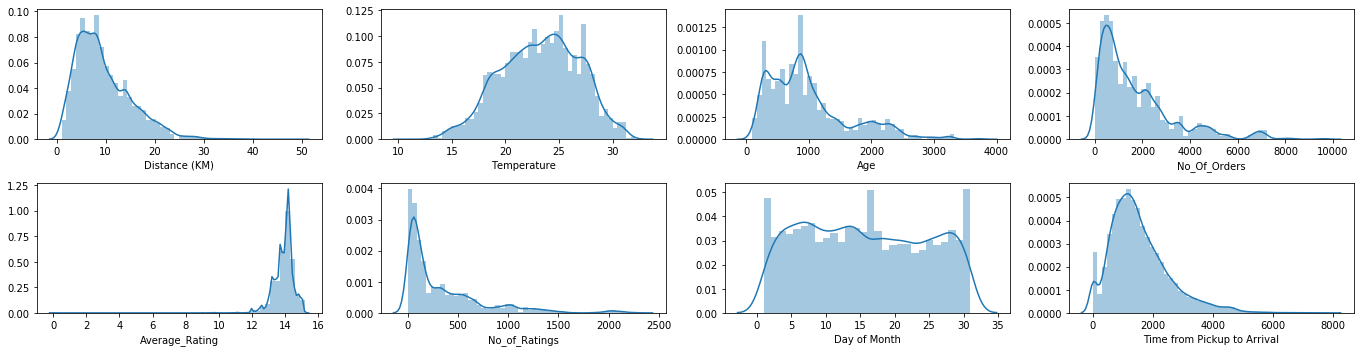

In [27]:
# distribution plot 
rows = 2
cols = 4
# setup layout for subplots
fig, ax = plt.subplots(nrows=rows, ncols=cols, figsize=(19,5))

# get number of columns
columns_dist = ['Distance (KM)', 'Temperature','Age','No_Of_Orders',
                'Average_Rating','No_of_Ratings','Day of Month','Time from Pickup to Arrival']
index = 0

for row in range(rows):
    for col in range(cols):
        sns.distplot(train_prep[columns_dist[index]], ax=ax[row][col])
        index +=1

# fix squeezed layout
plt.tight_layout()

# Bivariate Plots
---

In [20]:
train_prep.columns

Index(['Order No', 'Platform Type', 'Customer Type', 'Day of Month',
       'Weekday (Mo = 1)', 'Placement - Time', 'Confirmation - Time',
       'Arrival at Pickup - Time', 'Pickup - Time',
       'Arrival at Destination - Time', 'Distance (KM)', 'Temperature',
       'Pickup Lat', 'Pickup Long', 'Destination Lat', 'Destination Long',
       'Rider Id', 'Time from Pickup to Arrival', 'No_Of_Orders', 'Age',
       'Average_Rating', 'No_of_Ratings'],
      dtype='object')

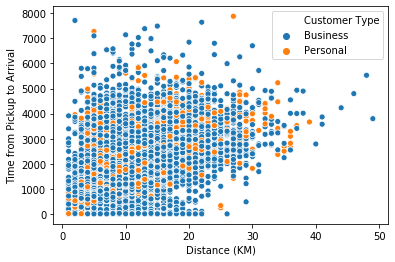

In [22]:
sns.scatterplot(x='Distance (KM)', y='Time from Pickup to Arrival', data=train_prep, hue='Customer Type')

NB. 
distance is having a positive linear correlation with the target.
<br>
filtering with customer type, we can observe that the business contributes more towards the linear relationship.
<br>
this was an obvious case because based on the composition plot of the customer type the business was contributing more.

# **Linear Rregression Assumptions**
---

```python 
#transformed histogram and normal probability plot
    sns.distplot(train_assump[column], fit=norm)
    fig = plt.figure()
    res = stats.probplot(train_assump[column], plot=plt)

# apply log
train_assump[column] = np.log(train_assump[column])


```

In [ ]:
# make a copy for easy backup
train_assump = train_riders.copy()

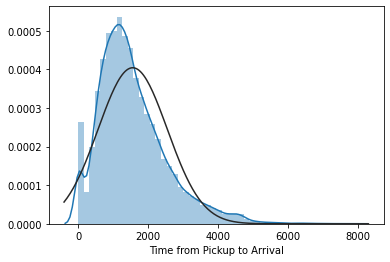

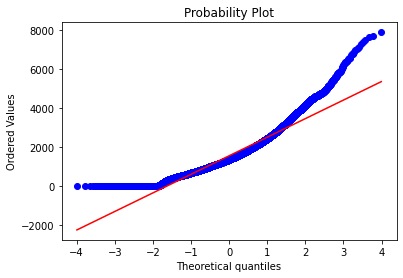

In [81]:
#transformed histogram and normal probability plot
sns.distplot(train_assump['Time from Pickup to Arrival'], fit=norm)
fig = plt.figure()
res = stats.probplot(train_assump['Time from Pickup to Arrival'], plot=plt)


**Sources**
----
[Train-Test-split](https://glassboxmedicine.com/2019/09/15/best-use-of-train-val-test-splits-with-tips-for-medical-data/)

[Decompose Date Time](https://medium.com/@swethalakshmanan14/simple-ways-to-extract-features-from-date-variable-using-python-60c33e3b0501)

[find drop duplicate columns](https://thispointer.com/how-to-find-drop-duplicate-columns-in-a-dataframe-python-pandas/)